In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from src.DMM_EM.WatsonEM import kummer_log
from scipy.special import gammaln
import h5py as h5

In [2]:
def draw_sphere(ax,num_lines=20):

    # draw sphere
    u, v = np.mgrid[0:2*np.pi:2*num_lines*1j, 0:np.pi:num_lines*1j]
    # u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)

    ax.plot_wireframe(x, y, z, color="k", alpha=0.1, zorder=3)
    # remove ticks
    ax.set_xticks([-1,1])
    ax.set_yticks([-1,1])
    ax.set_zticks([-1,1])
    ax.set_aspect('equal')
    
    # remove axes
    ax.set_axis_off()

    # keep the three main axes but remove the gray area in the middle of the 3d plot
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    
    return ax

def add_points_to_sphere(ax,P):
    num_points = P.shape[1] 
    # plot every second as red and every other second as green
    ax.scatter(P[0,:num_points//2], P[1,:num_points//2], P[2,:num_points//2], color='r', s=1, alpha=0.5,zorder=1)
    ax.scatter(P[0,num_points//2:], P[1,num_points//2:], P[2,num_points//2:], color='g', s=1, alpha=0.5,zorder=1)
    if P.shape[1]<3:
        ax.plot([0, P[0,0]], [0, P[1,0]], [0, P[2,0]], color='r')
        ax.plot([0, P[0,1]], [0, P[1,1]], [0, P[2,1]], color='g')

    return ax

def get_cmaps():
    # Initialize a dictionary to store the colormaps
    cmaps = []

    # cmaps[1]: White to Pink
    cmaps.append(np.column_stack([np.linspace(1, 0, 256), np.linspace(1, 0.5, 256), np.linspace(1, 0.5, 256)]))

    # cmaps[2]: White to Purple
    cmaps.append(np.column_stack([np.linspace(1, 0.5, 256), np.linspace(1, 0, 256), np.linspace(1, 0.5, 256)]))

    # cmaps[3]: White to Blue
    cmaps.append(np.column_stack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 1, 256)]))

    # cmaps[4]: White to Cyan
    cmaps.append(np.column_stack([np.linspace(1, 0, 256), np.linspace(1, 1, 256), np.linspace(1, 1, 256)]))

    # cmaps[5]: White to Magenta
    cmaps.append(np.column_stack([np.linspace(1, 1, 256), np.linspace(1, 0, 256), np.linspace(1, 1, 256)]))

    # cmaps[6]: White to Yellow
    cmaps.append(np.column_stack([np.linspace(1, 1, 256), np.linspace(1, 1, 256), np.linspace(1, 0, 256)]))

    # cmaps[7]: White to Orange
    cmaps.append(np.column_stack([np.linspace(1, 1, 256), np.linspace(1, 0.5, 256), np.linspace(1, 0, 256)]))

    # cmaps[8]: White to Navy
    cmaps.append(np.column_stack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0.5, 256)]))

    # cmaps[9]: White to Teal
    cmaps.append(np.column_stack([np.linspace(1, 0, 256), np.linspace(1, 0.5, 256), np.linspace(1, 0.5, 256)]))

    # cmaps[10]: White to Violet
    cmaps.append(np.column_stack([np.linspace(1, 0.5, 256), np.linspace(1, 0, 256), np.linspace(1, 1, 256)]))
    
    return cmaps

def add_contour_to_sphere(ax,params,num_grid_points=1000,model='watson',threshold=0.95,az=None,el=None):
    K = params['pi'].shape[0]
    # get faces
    theta, phi = np.linspace(0, np.pi, num_grid_points), np.linspace(0, 2 * np.pi, 2*num_grid_points)
    theta, phi = np.meshgrid(theta, phi)
    r = 1  # radius of the sphere

    # Sphere coordinates
    X = r * np.sin(theta) * np.cos(phi)
    Y = r * np.sin(theta) * np.sin(phi)
    Z = r * np.cos(theta)
    # Create the vertices for all faces using slicing and reshaping
    X_faces = np.array([X[:-1, :-1], X[1:, :-1], X[1:, 1:], X[:-1, 1:]]).transpose(1, 2, 0).reshape(-1, 4, 3)
    Y_faces = np.array([Y[:-1, :-1], Y[1:, :-1], Y[1:, 1:], Y[:-1, 1:]]).transpose(1, 2, 0).reshape(-1, 4, 3)
    Z_faces = np.array([Z[:-1, :-1], Z[1:, :-1], Z[1:, 1:], Z[:-1, 1:]]).transpose(1, 2, 0).reshape(-1, 4, 3)

    # Stack X, Y, Z to create the full vertex list (Nx4x3 array)
    verts = np.stack((X_faces, Y_faces, Z_faces), axis=-1).reshape(-1, 4, 3)
    vert_midpoint = np.mean(verts, axis=1)

    if az is not None:
        R_az = np.array([[np.cos(az),-np.sin(az),0],[np.sin(az),np.cos(az),0],[0,0,1]])
        R_el = np.array([[1,0,0],[0,np.cos(el),-np.sin(el)],[0,np.sin(el),np.cos(el)]])
        vert_location = R_az @ R_el @ vert_midpoint.T
        #binarize
        vert_location = (vert_location[0]>0).astype(bool)

    # vert_midpoint = np.array(vert_midpoint)
    num_faces = len(verts)
    
    #calculate colors
    c = np.zeros((num_faces,K))
    for k in range(K):
        if model=='watson':
            M2 = kummer_log(params['kappa'][k],0.5,1.5)
            Cp = gammaln(1.5)-np.log(2)-1.5*np.log(np.pi)-M2

            c[:,k] = np.log(params['pi'][k]) + Cp + params['kappa'][k]*((params['mu'][:,k] @ vert_midpoint.T)**2)

            # for i in range(num_faces):
            #     c[i,k] = np.log(params['pi'][k]) + Cp + params['kappa'][k]*((params['mu'][:,k] @ vert_midpoint[i])**2)
        elif model=='ACG':
            Cp = gammaln(1.5)-np.log(2)-1.5*np.log(np.pi)
            logdeta = np.log(np.linalg.det(params['L'][k]))
            L_inv = np.linalg.inv(params['L'][k])

            for i in range(num_faces):
                B = vert_midpoint[i] @ L_inv @ vert_midpoint[i]
                c[i,k] = np.log(params['pi'][k]) + Cp-0.5*logdeta-1.5*np.log(B)
        else:
            raise ValueError('Model not implemented')
        
    # normalize to values between 0 and 1
    for k in range(K):
        c[:,k] = (c[:,k] - c[:,k].min()) / (c[:,k].max() - c[:,k].min())
    # c = (c - c.min()) / (c.max() - c.min())
    # print(np.min(c),np.max(c[c<1]))

    # set values below threshold to 0
    c_show = np.zeros(c.shape,dtype=bool)
    for k in range(K):  
        c_show[:,k] = c[:,k] > threshold
        # print(c_show[:,k].sum())
        c[c_show[:,k],k] = (c[c_show[:,k],k] - c[c_show[:,k],k].min()) / (c[c_show[:,k],k].max() - c[c_show[:,k],k].min())

    #create K color maps
    cmaps = get_cmaps()
    # norm = plt.Normalize(c.min(), c.max())
    colors = np.zeros((K,num_faces,4))
    for k in range(K):
        colors[k,c_show[:,k],:3] = cmaps[k][(c[c_show[:,k],k]*255).astype(np.uint8)]
        colors[k,c_show[:,k],-1] = 1.0
    
        # Plot the collection of faces
        for foreground in [True,False]:
            if foreground:
                poly = Poly3DCollection(verts[~vert_location], facecolors=colors[k][~vert_location], edgecolor='k', linewidths=0,zorder=2)
            else:
                poly = Poly3DCollection(verts[vert_location], facecolors=colors[k][vert_location], edgecolor='k', linewidths=0,zorder=4)
            ax.add_collection3d(poly)
    return ax


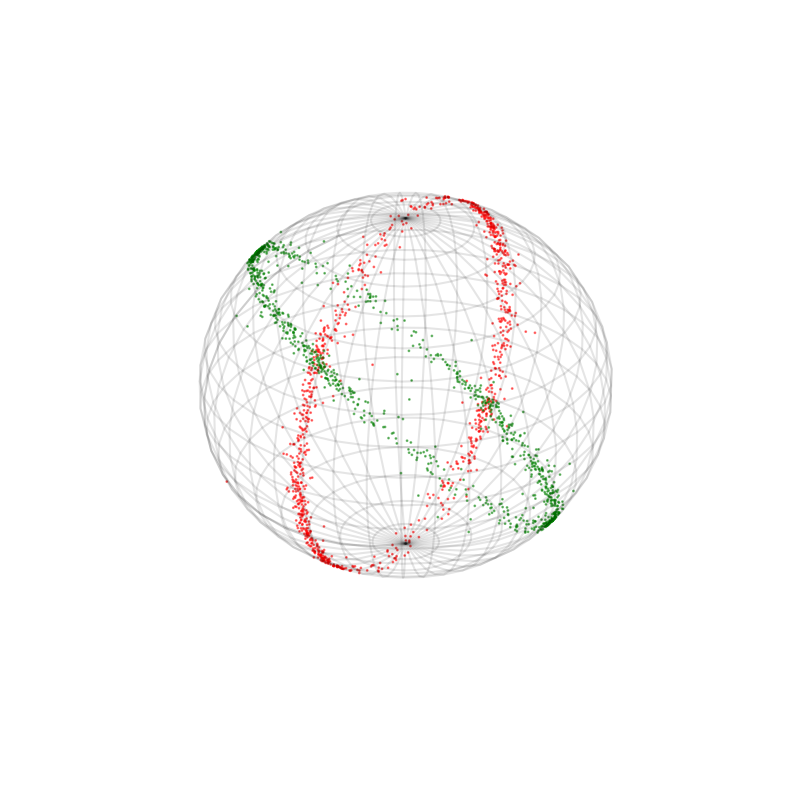

In [110]:
# just points
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'}, figsize=(10,10))
ax = draw_sphere(ax)
data = h5.File('fits/cluster_data.h5','r')['data'][:]
ax = add_points_to_sphere(ax,data.T)
ax.view_init(30, 75)
fig.savefig('figs/python_points.png',dpi=300,bbox_inches='tight')

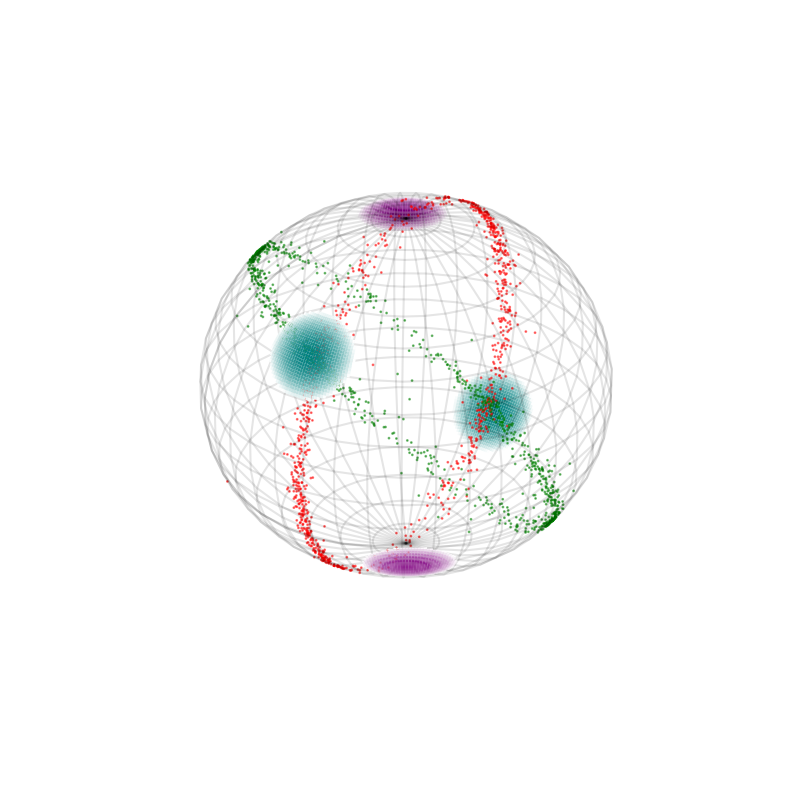

In [111]:
# watson K=2
params = {}
params['pi'] = np.loadtxt('fits/watson_centroids_pi_K=2.txt')
params['mu'] = np.loadtxt('fits/watson_centroids_mu_K=2.txt')
params['kappa'] = np.loadtxt('fits/watson_centroids_kappa_K=2.txt')

fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'}, figsize=(10,10))
ax = add_contour_to_sphere(ax,params,model='watson',threshold=0.95,num_grid_points=200,az=30,el=75)
ax = draw_sphere(ax)
add_points_to_sphere(ax,data.T)
ax.view_init(30, 75)
fig.savefig('figs/python_watson_K=2.png',dpi=300,bbox_inches='tight')

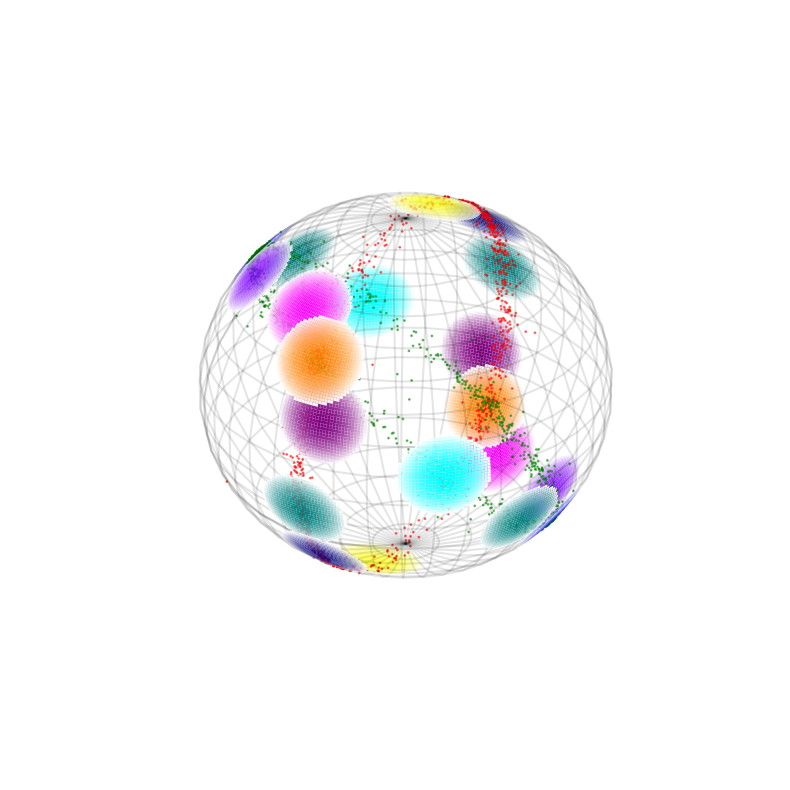

In [112]:
# watson K=10
params = {}
params['pi'] = np.loadtxt('fits/watson_centroids_pi_K=10.txt')
params['mu'] = np.loadtxt('fits/watson_centroids_mu_K=10.txt')
params['kappa'] = np.loadtxt('fits/watson_centroids_kappa_K=10.txt')

fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'}, figsize=(10,10))
ax = draw_sphere(ax)
ax = add_contour_to_sphere(ax,params,model='watson',threshold=0.95,num_grid_points=200,az=30,el=75)
ax = add_points_to_sphere(ax,data.T)
# view 
ax.view_init(30, 75)
fig.savefig('figs/python_watson_K=10.png',dpi=300,bbox_inches='tight')

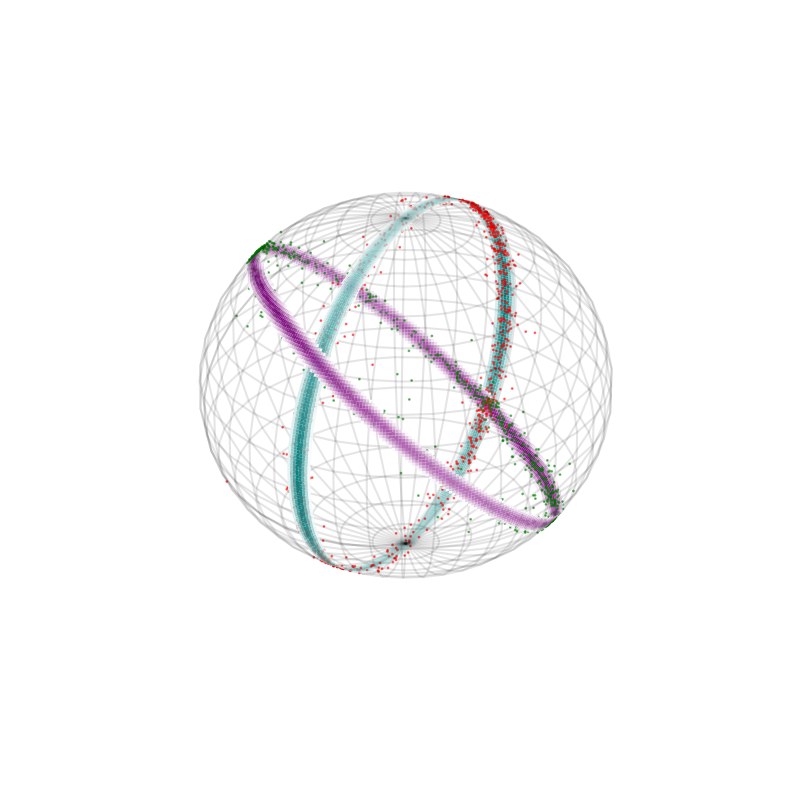

In [113]:
# ACG K=2
K = 2
params = {}
params['pi'] = np.loadtxt('fits/ACG_centroids_pi_K=2.txt')
params['L'] = np.zeros((2,3,3))
for k in range(K):
    params['L'][k] = np.loadtxt('fits/ACG_centroids_K=2'+str(k)+'.txt')

fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'}, figsize=(10,10))
ax=draw_sphere(ax)
ax=add_contour_to_sphere(ax,params,model='ACG',threshold=0.75,num_grid_points=200,az=30,el=75)
ax=add_points_to_sphere(ax,data.T)
ax.view_init(30, 75)
fig.savefig('figs/python_ACG_K=2.png',dpi=300,bbox_inches='tight')

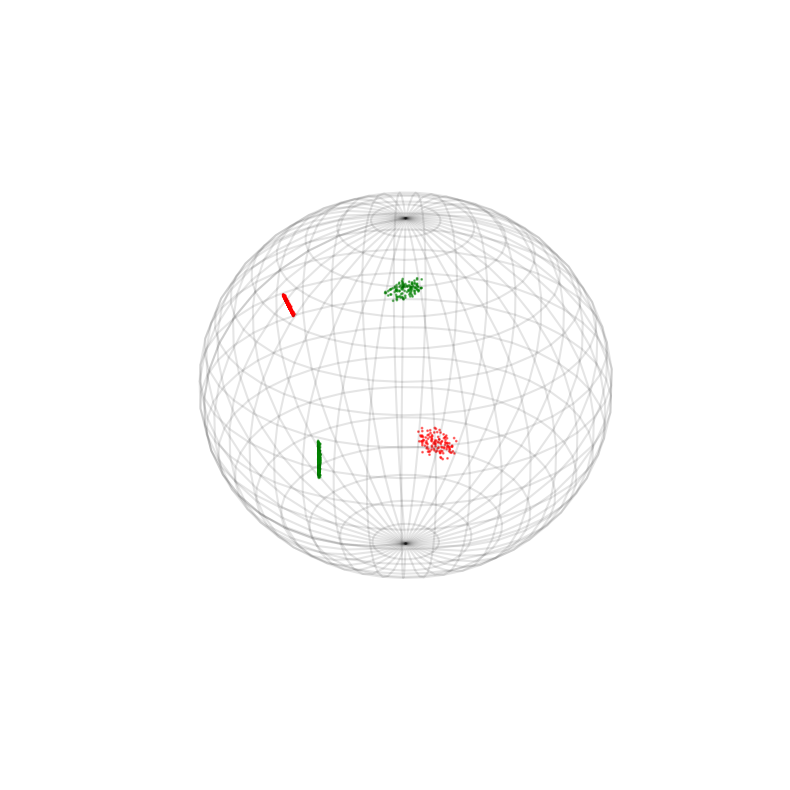

In [8]:
# just points
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'}, figsize=(10,10))
ax = draw_sphere(ax)
data = h5.File('fits/complex_data_noise3.h5','r')['U'][:]
data = np.real(data)
ax = add_points_to_sphere(ax,data.T)
ax.view_init(30, 75)
# fig.savefig('figs/python_points.png',dpi=300,bbox_inches='tight')